In [ ]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile 
import numpy as np
import pydicom as dicom
from pathlib import Path
import itertools
import torch
from torchvision.datasets import ImageFolder
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader



: 

In [2]:
patient_id, filelist = [],[]
for zipfile_path in list(Path("20219").glob('*.zip')): #itertools.islice(zipfile_paths, 100):
    with zipfile.ZipFile(zipfile_path) as zf:
        patient_id.append(zipfile_path.stem)
        filelist.append(zf.namelist()[15])
df_image = pd.DataFrame({'eid': patient_id, 'file_path': filelist})
df_image['file_path'] = df_image['eid']  + '.zip/' + df_image['file_path']
print(df_image.head())
print(df_image.shape)

                 eid                                          file_path
0  2009114_20219_2_0  2009114_20219_2_0.zip/1.3.12.2.1107.5.2.19.455...
1  1539636_20219_2_0  1539636_20219_2_0.zip/1.3.12.2.1107.5.2.19.145...
2  1728592_20219_2_0  1728592_20219_2_0.zip/1.3.12.2.1107.5.2.19.145...
3  1480528_20219_2_0  1480528_20219_2_0.zip/1.3.12.2.1107.5.2.19.145...
4  1334757_20219_2_0  1334757_20219_2_0.zip/1.3.12.2.1107.5.2.19.455...
(11525, 2)


       eid      20219
0  1000010  20219_2_0
1  1000104  20219_2_0
2  1000196  20219_2_0
3  1000254  20219_2_0
4  1000370  20219_2_0
       eid  Gender
0  1000010       0
1  1000028       0
2  1000034       1
3  1000045       1
4  1000052       0
       eid      20219  Gender
0  1000010  20219_2_0       0
1  1000104  20219_2_0       0
2  1000196  20219_2_0       1
3  1000196  20219_3_0       1
4  1000254  20219_2_0       0
eid       0
20219     0
Gender    0
dtype: int64
                 eid  Gender
0  1000010_20219_2_0       0
1  1000104_20219_2_0       0
2  1000196_20219_2_0       1
3  1000196_20219_3_0       1
4  1000254_20219_2_0       0
(56768, 2)
Gender
0    29573
1    27195
Name: count, dtype: int64


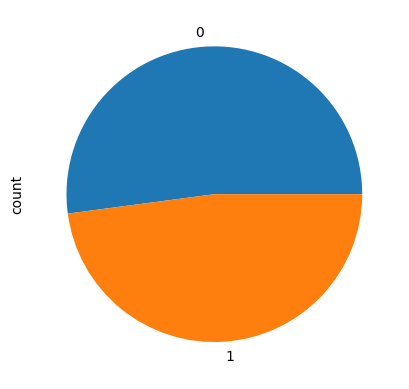

In [8]:
#Creating age and gender dataframes
con = sqlite3.connect("ukbiobank.db")

df1 = pd.read_sql("select * from '20219';", con)
df1.drop(columns=['instance_index', 'array_index'], inplace = True)
print(df1.head())

#df2 = pd.read_sql("select * from '34';", con)
#df2.drop(columns=['instance_index', 'array_index'], inplace= True)
#df2.rename(columns={"34": "Year of Birth"}, inplace=True)

#df3 = pd.read_sql("select * from '53';", con)
#df3.rename(columns={"53": "Date of Visit"}, inplace=True)
#df3['Date of Visit'] = pd.to_datetime(df3['Date of Visit'], errors='coerce')
#df3['Year of Visit'] = df3['Date of Visit'].dt.year
#df3.drop(columns=['instance_index', 'array_index', 'Date of Visit'], inplace= True)

df4 = pd.read_sql("select * from '31';", con)
df4.drop(columns=['instance_index', 'array_index'], inplace= True)
df4.rename(columns={"31": "Gender"}, inplace=True)
print(df4.head())

df_merged = df1.merge(df4, on = 'eid', how = 'inner')
#df_merged["Age"] = df_merged['Year of Visit'] - df_merged['Year of Birth']
#df_merged.loc[(df_merged.Age < 55),  'AgeGroup'] = '0'
#df_merged.loc[(df_merged.Age > 65),  'AgeGroup'] = '1'
#df_age = df_merged.drop(columns=['Year of Birth', 'Year of Visit', 'Gender', 'Age'])
print(df_merged.head())

#df_age = df_merged.drop(columns=['Year of Birth', 'Year of Visit', 'Age', 'AgeGroup'])
df_gender = df_merged.dropna()
print(df_gender.isna().sum())


df_gender['eid'] = df_gender['eid'].astype(str)
df_gender['20219'] = df_gender['20219'].astype(str)
df_gender['eid'] = df_gender['eid'].str.cat(df_gender['20219'], sep='_').str.replace(' ', '_')
df_gender.drop(columns=['20219'], inplace= True)
print(df_gender.head())
print(df_gender.shape)
#sns.kdeplot(df['Age'])
## sns.distplot(df['Age'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth':3}, label = Age)
#plt.show()  

gender_dist = df_gender['Gender'].value_counts()
print(gender_dist)
gender_dist.plot.pie()
con.close()


# df_age['AgeGroup'] = pd.to_numeric(df_age['AgeGroup'], errors='coerce').astype(pd.Int64Dtype())

In [9]:
#df_age['eid'] =  df_age['eid'].astype(str)
#df_image['eid'] = df_image['eid'].astype(str)

df_final = df_image.merge(df_gender, on = 'eid', how = 'inner')
print(df_final.head())
print(df_final.shape)

                 eid                                          file_path   
0  2009114_20219_2_0  2009114_20219_2_0.zip/1.3.12.2.1107.5.2.19.455...  \
1  1539636_20219_2_0  1539636_20219_2_0.zip/1.3.12.2.1107.5.2.19.145...   
2  1728592_20219_2_0  1728592_20219_2_0.zip/1.3.12.2.1107.5.2.19.145...   
3  1480528_20219_2_0  1480528_20219_2_0.zip/1.3.12.2.1107.5.2.19.145...   
4  1334757_20219_2_0  1334757_20219_2_0.zip/1.3.12.2.1107.5.2.19.455...   

   Gender  
0       0  
1       1  
2       1  
3       0  
4       0  
(11525, 3)


In [11]:
#Creating the train and test csv files

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_final, test_size=0.2)
train_df.to_csv('train_gender.csv', index = False)
test_df.to_csv('test_gender.csv', index = False)

In [12]:
train_gender = pd.read_csv('train.csv')
test_gender = pd.read_csv('test.csv')
# sample_submission = pd.read_csv('sample_submission_I5njJSF.csv')
train_gender.head()
train_gender.shape

(9220, 3)

In [13]:
df = pd.read_csv('train_gender.csv')
column_data_type = df['Gender'].dtype
print(column_data_type)

int64
